In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import shap
import joblib


In [28]:
# Helper: mount drive (for Colab)
try:
    from google.colab import drive
    DRIVE_AVAILABLE = True
except Exception:
    DRIVE_AVAILABLE = False

if DRIVE_AVAILABLE:
    print('Mounting Google Drive...')
    drive.mount('/content/drive')


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# 2. Load data - update path to your file in Drive


# 2. Load Excel (.xlsx) file with pandas
import pandas as pd

# UPDATE the path to your actual file location
file_path = '/content/drive/MyDrive/Colab Notebooks/Customer_Chunk_Project/Telco_customer_churn.xlsx'

# If your file has multiple sheets, you can specify sheet_name=...
df = pd.read_excel(file_path)

# Preview
print(df.shape)
df.head()



(7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [30]:
import pandas as pd

# 3. Basic EDA & preprocessing
# Convert Total Charges to numeric if necessary
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Quick cleaning: drop CustomerID-like columns
drop_cols = [c for c in ['CustomerID', 'Count', 'Lat Long'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

# Target
TARGET = 'Churn Label' if 'Churn Label' in df.columns else 'Churn'
if TARGET not in df.columns and 'Churn Value' in df.columns:
    # attempt to map churn value
    df['Churn'] = df['Churn Value']
    TARGET = 'Churn'

# If target is textual like Yes/No -> map to 1/0
if df[TARGET].dtype == 'object':
    df[TARGET] = df[TARGET].str.lower().map({'yes':1,'no':0,'true':1,'false':0,'1':1,'0':0})

# Drop rows where target missing
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

# Feature list
features = [c for c in df.columns if c != TARGET]

# Separate numeric and categorical
numeric_feats = df[features].select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats = df[features].select_dtypes(include=['object','category','bool']).columns.tolist()

# Some columns are numeric but actually categorical (like Zip Code); optionally treat small-cardinality numerics as categorical
for c in numeric_feats.copy():
    if df[c].nunique() < 12:
        # treat as categorical
        numeric_feats.remove(c)
        cat_feats.append(c)

print('Numeric features:', numeric_feats)
print('Categorical features:', cat_feats)

# Train/test split
X = df[features]
y = df[TARGET].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_feats),
    ('cat', cat_pipeline, cat_feats)
])

Numeric features: ['Zip Code', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']
Categorical features: ['Country', 'State', 'City', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Reason', 'Churn Value']


In [31]:
# 4. Baseline model (LightGBM) in a pipeline
clf = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', clf)
])

# Quick baseline fit
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:,1]
preds = pipe.predict(X_test)
print('Baseline AUC:', roc_auc_score(y_test, probs))
print('Baseline F1:', f1_score(y_test, preds))
print(classification_report(y_test, preds))


[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [32]:
# 5. Hyperparameter tuning (RandomizedSearchCV) - optional faster search
param_dist = {
    'clf__n_estimators': [100, 300, 600],
    'clf__num_leaves': [31, 64, 128],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__reg_alpha': [0, 0.1, 1],
    'clf__reg_lambda': [0, 0.1, 1]
}

rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=25, scoring='roc_auc', cv=3, verbose=2, n_jobs=1, random_state=42)
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
best_pipe = rs.best_estimator_

# Evaluate best
probs = best_pipe.predict_proba(X_test)[:,1]
preds = best_pipe.predict(X_test)
auc = roc_auc_score(y_test, probs)
f1 = f1_score(y_test, preds)
print('Tuned AUC:', auc)
print('Tuned F1:', f1)
print(classification_report(y_test, preds))

# Save model
joblib.dump(best_pipe, 'lgbm_churn_pipeline.joblib')


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=1, clf__subsample=1.0; total time=   0.2s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=300, clf__num_leaves=31, clf__reg_alpha=0.1, clf__reg_lambda=0, clf__subsample=1.0; total time=   0.3s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=31, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.6; total time=   0.2s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=1.0; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=1.0; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=1, clf__subsample=1.0; total time=   0.5s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=100, clf__num_leaves=128, clf__reg_alpha=0.1, clf__reg_lambda=1, clf__subsample=0.8; total time=   0.2s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=0.1, clf__reg_lambda=0, clf__subsample=0.8; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=0.1, clf__reg_lambda=0, clf__subsample=0.8; total time=   0.5s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=0.1, clf__reg_lambda=0, clf__subsample=0.8; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=1, clf__subsample=1.0; total time=   0.2s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=300, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=1, clf__subsample=0.8; total time=   0.3s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=300, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0, clf__subsample=0.8; total time=   1.0s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=300, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0, clf__subsample=0.8; total time=   0.9s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=300, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0, clf__subsample=0.8; total time=   0.9s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.8; total time=   0.5s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.8; total time=   0.5s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=600, clf__num_leaves=64, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.8; total time=   0.7s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=600, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=0.8; total time=   2.1s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=600, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=0.8; total time=   1.0s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.01, clf__n_estimators=300, clf__num_leaves=64, clf__reg_alpha=0.1, clf__reg_lambda=0, clf__subsample=0.6; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0, clf__subsample=1.0; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0, clf__subsample=1.0; total time=   0.4s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.01, clf__n_estimators=100, clf__num_leaves=64, clf__reg_alpha=0, clf__reg_lambda=0, clf__subsample=1.0; total time=   0.4s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=600, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=1.0; total time=   0.5s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=600, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=1.0; total time=   0.4s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=600, clf__num_leaves=31, clf__reg_alpha=0, clf__reg_lambda=0.1, clf__subsample=1.0; total time=   0.5s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__n_estimators=100, clf__num_leaves=31, clf__reg_alpha=0.1, clf__reg_lambda=0, clf__subsample=1.0; total time=   0.2s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=300, clf__num_leaves=128, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.6; total time=   0.3s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.05, clf__n_estimators=300, clf__num_leaves=128, clf__reg_alpha=1, clf__reg_lambda=0.1, clf__subsample=0.6; total time=   0.3s
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.01, clf__n_estimators=300, clf__num_leaves=64, clf__reg_alpha=0.1, clf__reg_lambda=0.1, clf__subsample=0.6; total time=   0.4s
[LightGBM] [Info] Number of positive: 996, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265176 -> initscore=-1.019239
[LightGBM] [Info] Start training from score -1.019239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


['lgbm_churn_pipeline.joblib']

Number of features after preprocessing: 1204


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


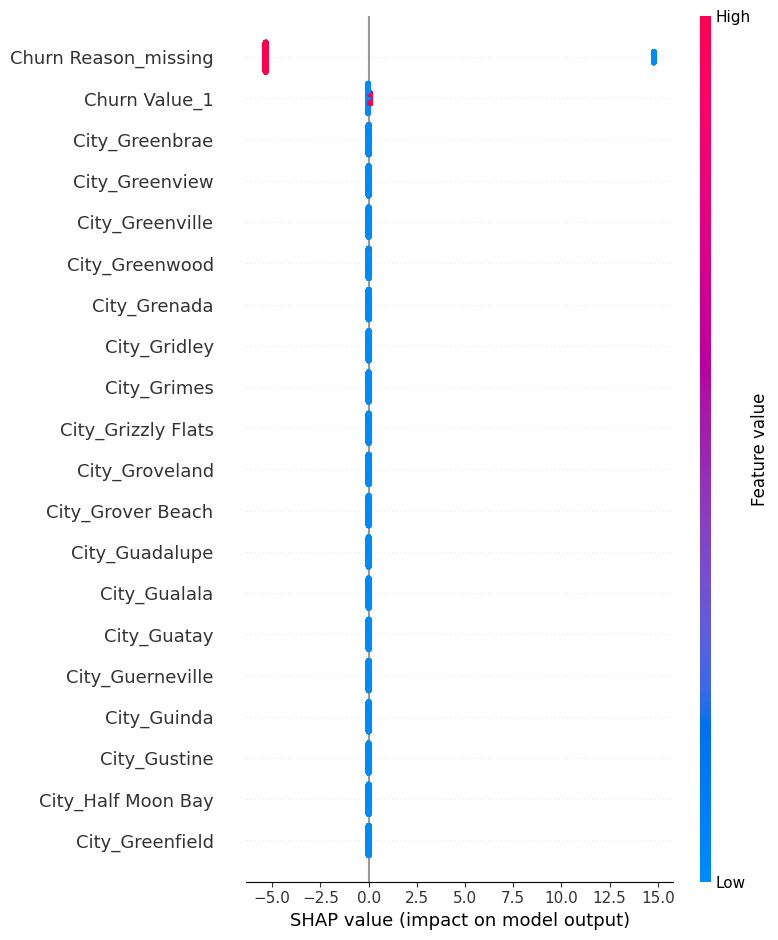

Top features by mean(|SHAP|): ['Churn Reason_missing', 'Churn Value_1', 'City_Greenbrae', 'City_Greenview', 'City_Greenville']


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

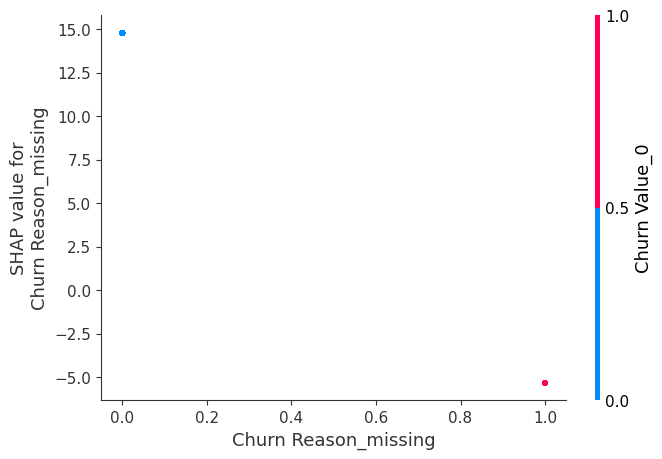

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

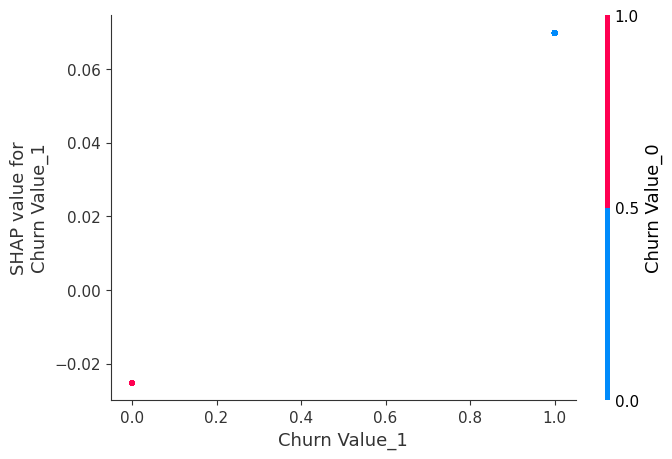

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

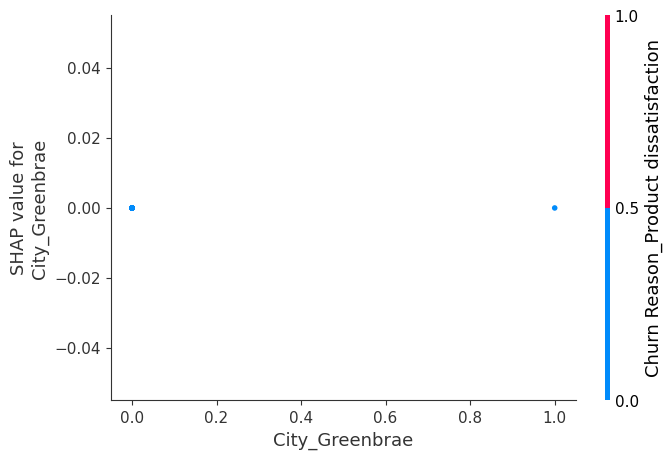

<Figure size 640x480 with 0 Axes>

In [33]:
# 6. SHAP explanation
# We need the transformed feature names after preprocessing for SHAP
# Get preprocessor and classifier separately
pre = best_pipe.named_steps['pre']
model = best_pipe.named_steps['clf']

# Build feature names
# numeric features remain in order; OneHotEncoder expands categorical
num_cols = numeric_feats
cat_ohe = []
if len(cat_feats) > 0:
    ohe = pre.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = ohe.get_feature_names_out(cat_feats).tolist()
    cat_ohe = cat_feature_names
feature_names = num_cols + cat_ohe
print('Number of features after preprocessing:', len(feature_names))

# Transform train data (to numpy)
X_train_trans = pre.transform(X_train)
X_test_trans = pre.transform(X_test)

# Convert sparse matrices to dense arrays for SHAP
if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

# SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)
# shap_values is an array/list depending on model; for binary it's [neg, pos]
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
else:
    shap_vals_pos = shap_values

# Global SHAP summary plot
shap.initjs()
plt.figure()
shap.summary_plot(shap_vals_pos, X_test_trans, feature_names=feature_names, show=True)
plt.savefig('shap_summary.png', bbox_inches='tight')

# Dependence plot for top features
# find top features by mean(|shap|)
mean_abs = np.abs(shap_vals_pos).mean(axis=0)
top_idx = np.argsort(mean_abs)[-5:][::-1]
top_features = [feature_names[i] for i in top_idx]
print('Top features by mean(|SHAP|):', top_features)
for feat in top_features[:3]:
    plt.figure()
    shap.dependence_plot(feat, shap_vals_pos, X_test_trans, feature_names=feature_names, show=True)
    plt.savefig(f'shap_dependence_{feat}.png', bbox_inches='tight')

Selected sample indices (in test set): [np.int64(9), np.int64(0), np.int64(367)]


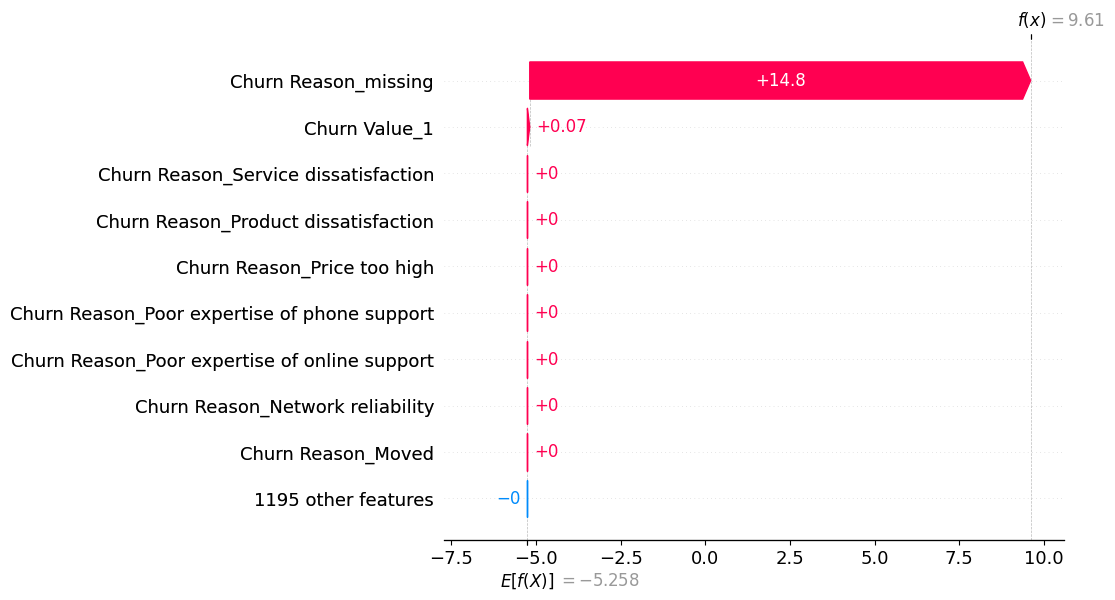

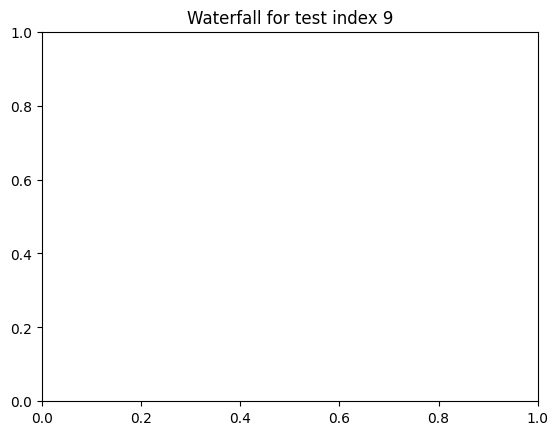

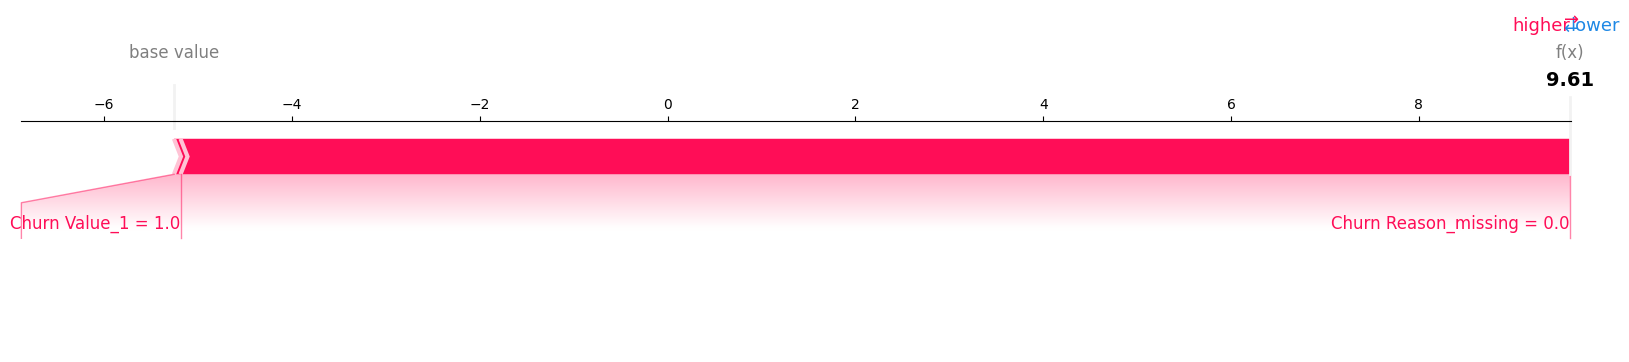

<Figure size 640x480 with 0 Axes>

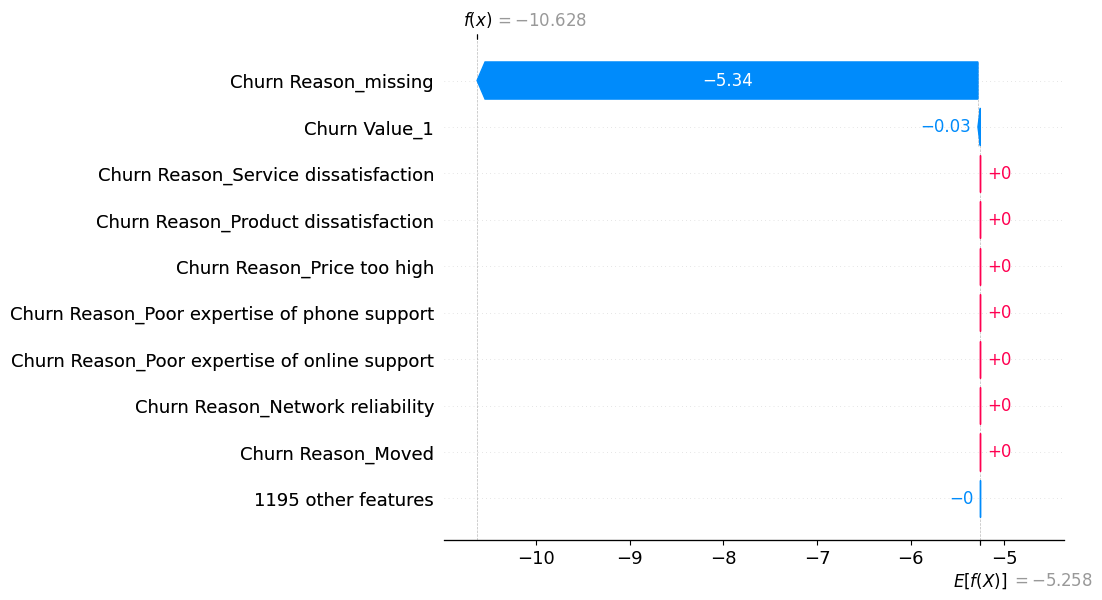

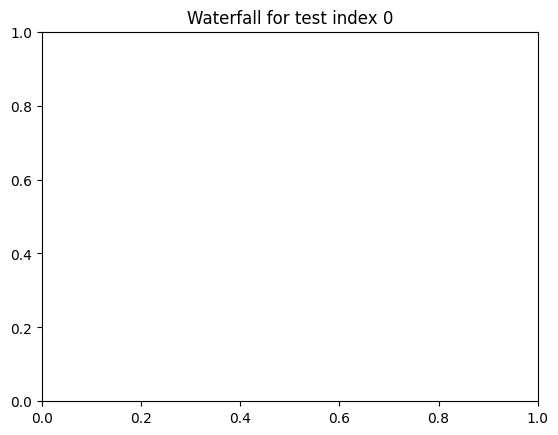

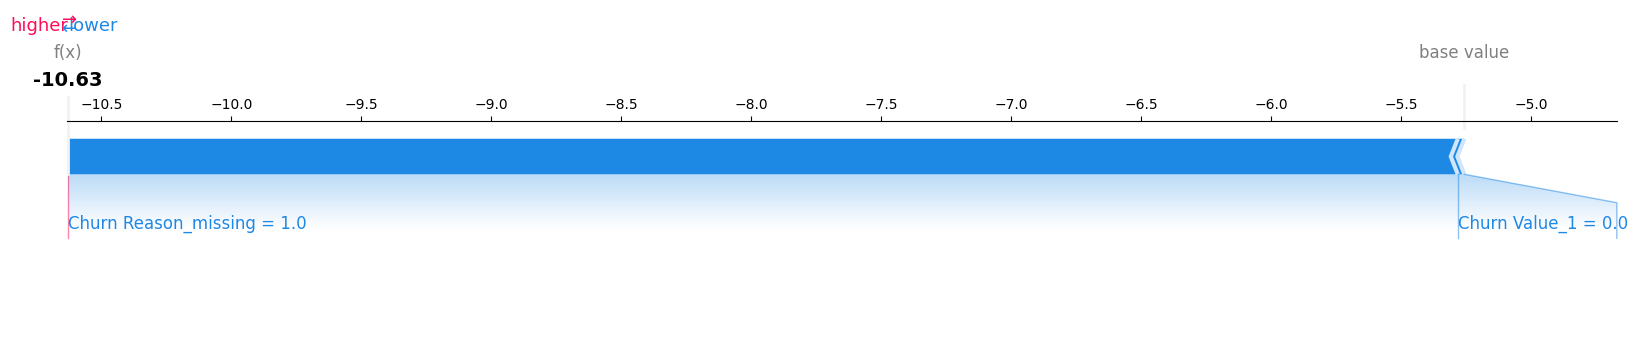

<Figure size 640x480 with 0 Axes>

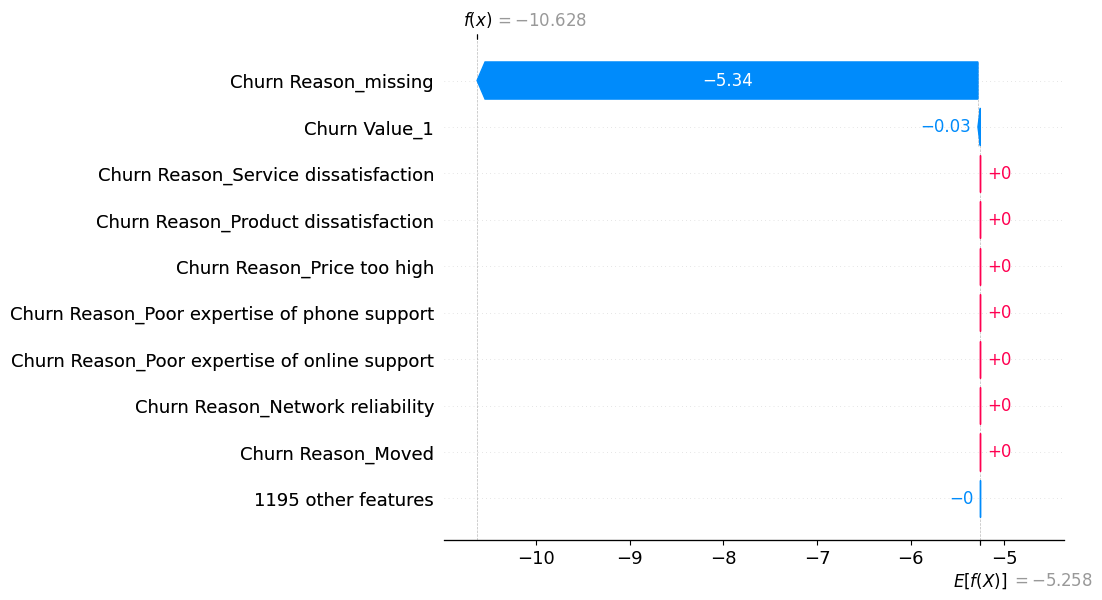

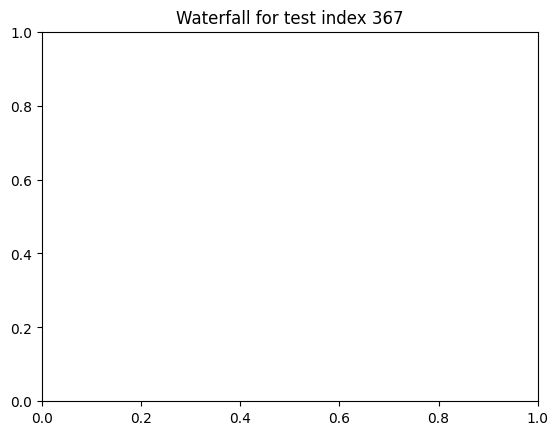

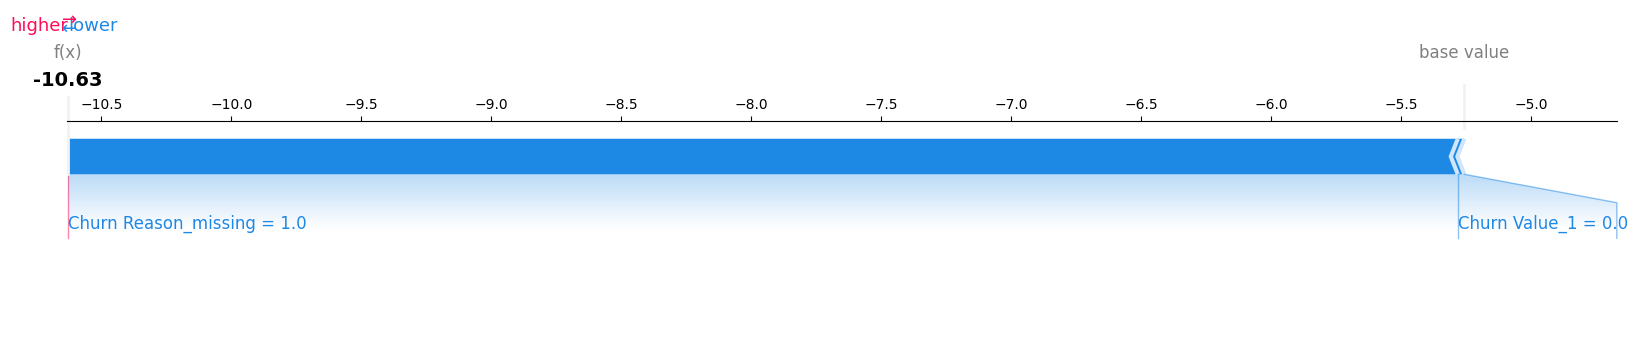

<Figure size 640x480 with 0 Axes>

In [34]:
# 7. Local explanations: select 5 customer profiles
# We'll pick: highest predicted churn prob, lowest prob, one misclassified churn, one misclassified not-churn, and a median case.
probs_all = probs
indices = np.arange(len(probs_all))
high_idx = indices[np.argmax(probs_all)]
low_idx = indices[np.argmin(probs_all)]
median_idx = indices[np.argsort(probs_all)[len(probs_all)//2]]
# misclassified churn (pred=0 but true=1) and misclassified not-churn (pred=1 but true=0)
mis_cl = None
mis_ncl = None
for i in indices:
    if preds[i]==0 and y_test.values[i]==1 and mis_cl is None:
        mis_cl = i
    if preds[i]==1 and y_test.values[i]==0 and mis_ncl is None:
        mis_ncl = i
# fallback if not found
sample_idxs = [high_idx, low_idx, median_idx]
if mis_cl is not None:
    sample_idxs.append(mis_cl)
if mis_ncl is not None:
    sample_idxs.append(mis_ncl)
# ensure unique and length 5
sample_idxs = list(dict.fromkeys(sample_idxs))[:5]
print('Selected sample indices (in test set):', sample_idxs)

# Create local plots
for i, idx in enumerate(sample_idxs):
    sv = shap_vals_pos[idx]
    x_row = X_test_trans[idx]
    # waterfall
    plt.figure()
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value, sv, feature_names=feature_names, max_display=10)
    plt.title(f'Waterfall for test index {idx}')
    plt.savefig(f'waterfall_{i}_idx{idx}.png', bbox_inches='tight')
    # force plot as html
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value, sv, x_row, feature_names=feature_names, matplotlib=True, show=True)
    plt.savefig(f'force_{i}_idx{idx}.png', bbox_inches='tight')


In [35]:
# 8. Export a CSV with predictions and key SHAP contributions for inspection
X_test_reset = X_test.reset_index(drop=True)
out = X_test_reset.copy()
out['y_true'] = y_test.reset_index(drop=True)
out['y_pred_prob'] = probs_all
out['y_pred'] = preds

# add top 10 shap contributions
for j in range(10):
    if j < len(feature_names):
        out[f'shap_contrib_{j+1}_feat'] = np.array(feature_names)[np.argsort(-np.abs(shap_vals_pos), axis=1)][:, j]
        out[f'shap_contrib_{j+1}_val'] = np.take_along_axis(shap_vals_pos, np.argsort(-np.abs(shap_vals_pos), axis=1), axis=1)[:, j]

out.to_csv('test_predictions_with_shap.csv', index=False)
print('Exported test_predictions_with_shap.csv and plot PNGs.')

# End of script
print('Done')


Exported test_predictions_with_shap.csv and plot PNGs.
Done


In [36]:
import os

OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Customer_Chunk_Project/output/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory created at: {OUTPUT_DIR}")

Output directory created at: /content/drive/MyDrive/Colab Notebooks/Customer_Chunk_Project/output/


Number of features after preprocessing: 1204


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


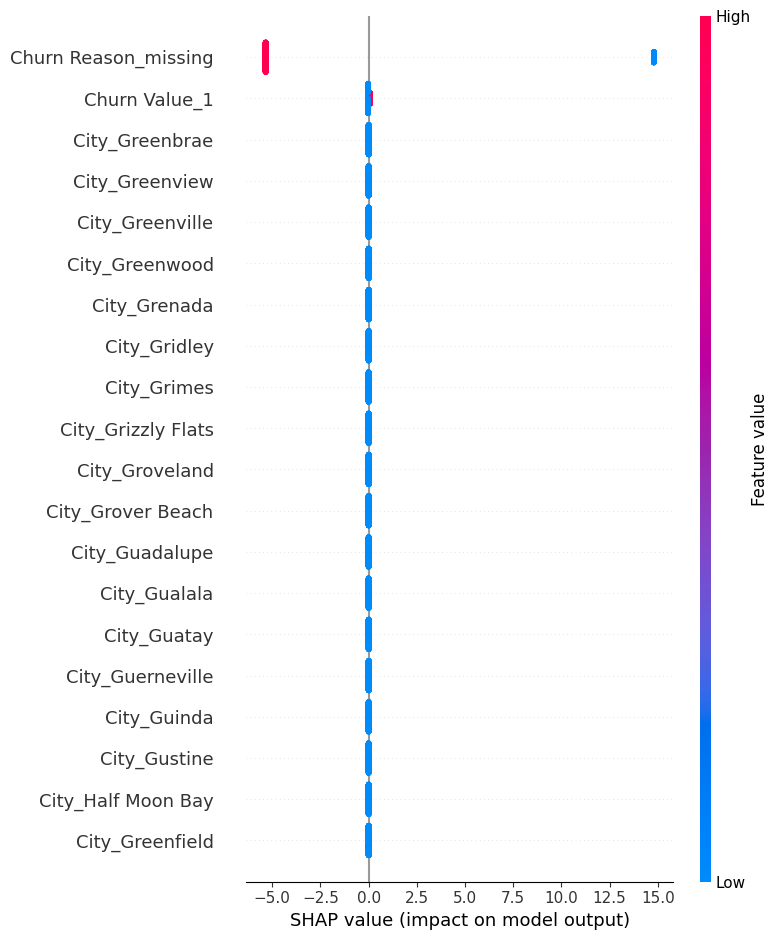

Top features by mean(|SHAP|): ['Churn Reason_missing', 'Churn Value_1', 'City_Greenbrae', 'City_Greenview', 'City_Greenville']


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

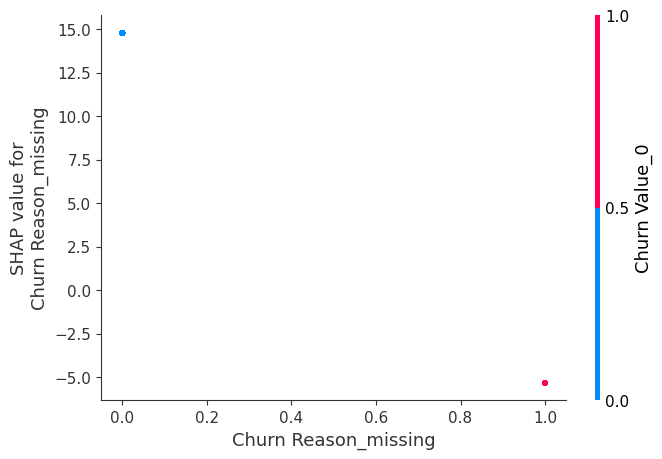

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

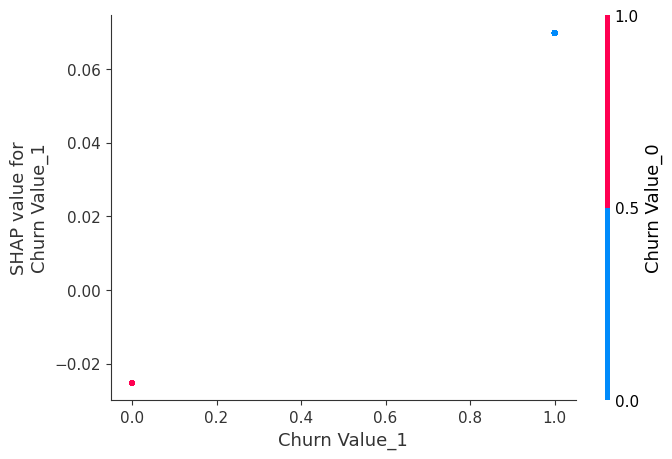

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

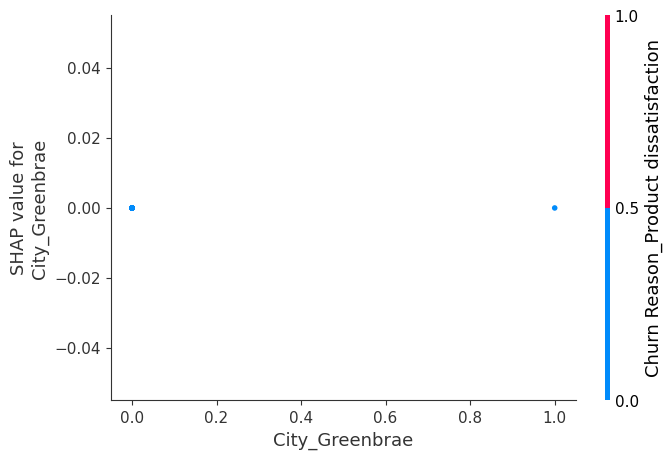

<Figure size 640x480 with 0 Axes>

In [37]:
# 6. SHAP explanation
# We need the transformed feature names after preprocessing for SHAP
# Get preprocessor and classifier separately
pre = best_pipe.named_steps['pre']
model = best_pipe.named_steps['clf']

# Build feature names
# numeric features remain in order; OneHotEncoder expands categorical
num_cols = numeric_feats
cat_ohe = []
if len(cat_feats) > 0:
    ohe = pre.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = ohe.get_feature_names_out(cat_feats).tolist()
    cat_ohe = cat_feature_names
feature_names = num_cols + cat_ohe
print('Number of features after preprocessing:', len(feature_names))

# Transform train data (to numpy)
X_train_trans = pre.transform(X_train)
X_test_trans = pre.transform(X_test)

# Convert sparse matrices to dense arrays for SHAP
if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

# SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)
# shap_values is an array/list depending on model; for binary it's [neg, pos]
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
else:
    shap_vals_pos = shap_values

# Global SHAP summary plot
shap.initjs()
plt.figure()
shap.summary_plot(shap_vals_pos, X_test_trans, feature_names=feature_names, show=True)
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary.png'), bbox_inches='tight')

# Dependence plot for top features
# find top features by mean(|shap|)
mean_abs = np.abs(shap_vals_pos).mean(axis=0)
top_idx = np.argsort(mean_abs)[-5:][::-1]
top_features = [feature_names[i] for i in top_idx]
print('Top features by mean(|SHAP|):', top_features)
for feat in top_features[:3]:
    plt.figure()
    shap.dependence_plot(feat, shap_vals_pos, X_test_trans, feature_names=feature_names, show=True)
    plt.savefig(os.path.join(OUTPUT_DIR, f'shap_dependence_{feat}.png'), bbox_inches='tight')

Selected sample indices (in test set): [np.int64(9), np.int64(0), np.int64(367)]


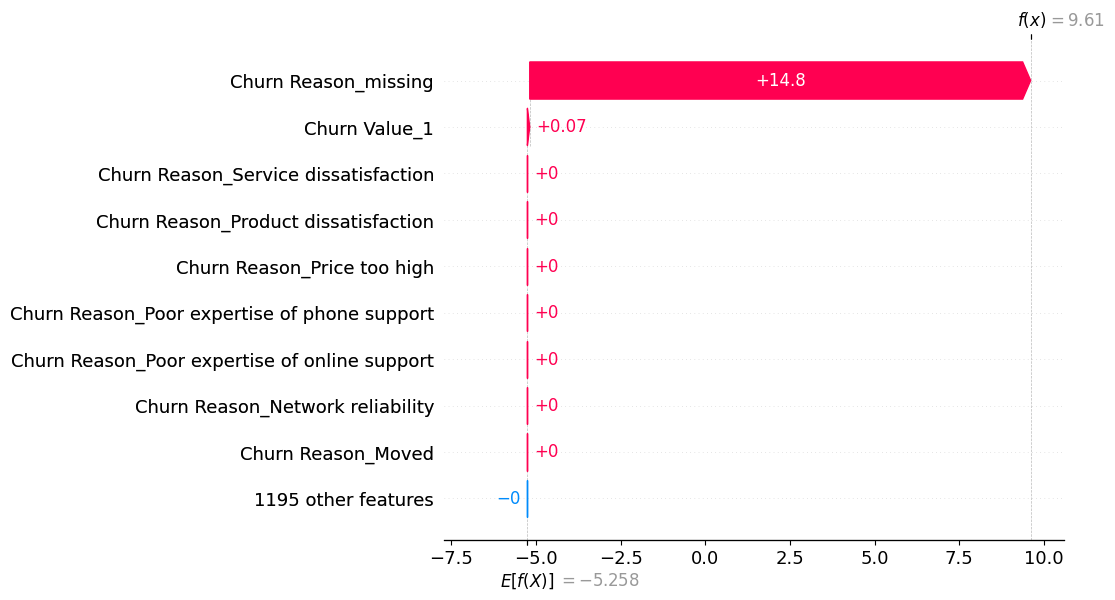

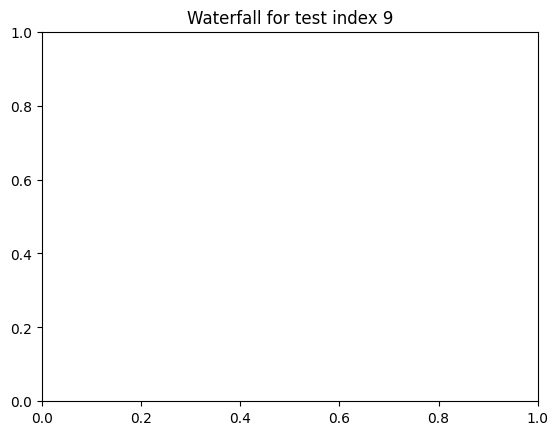

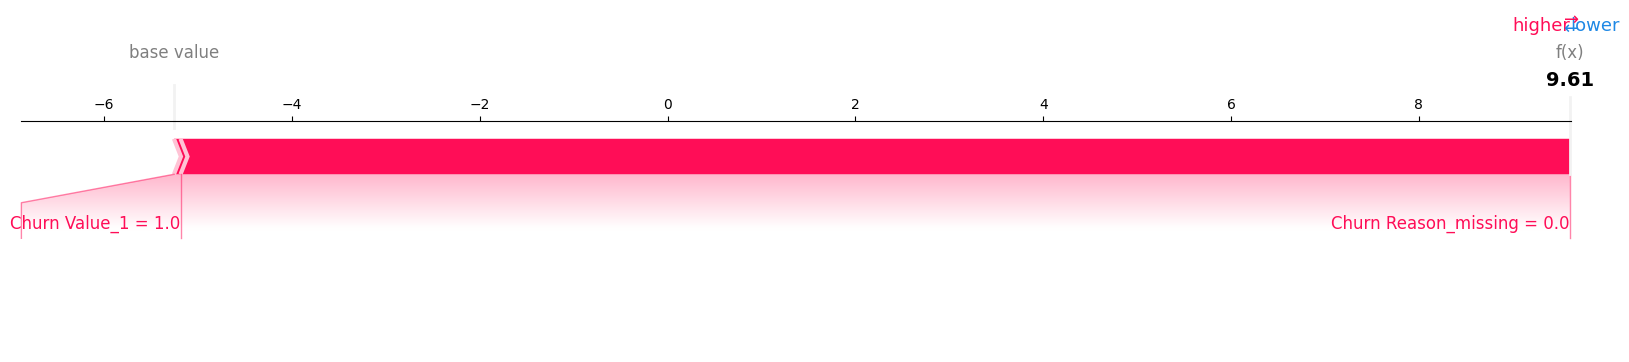

<Figure size 640x480 with 0 Axes>

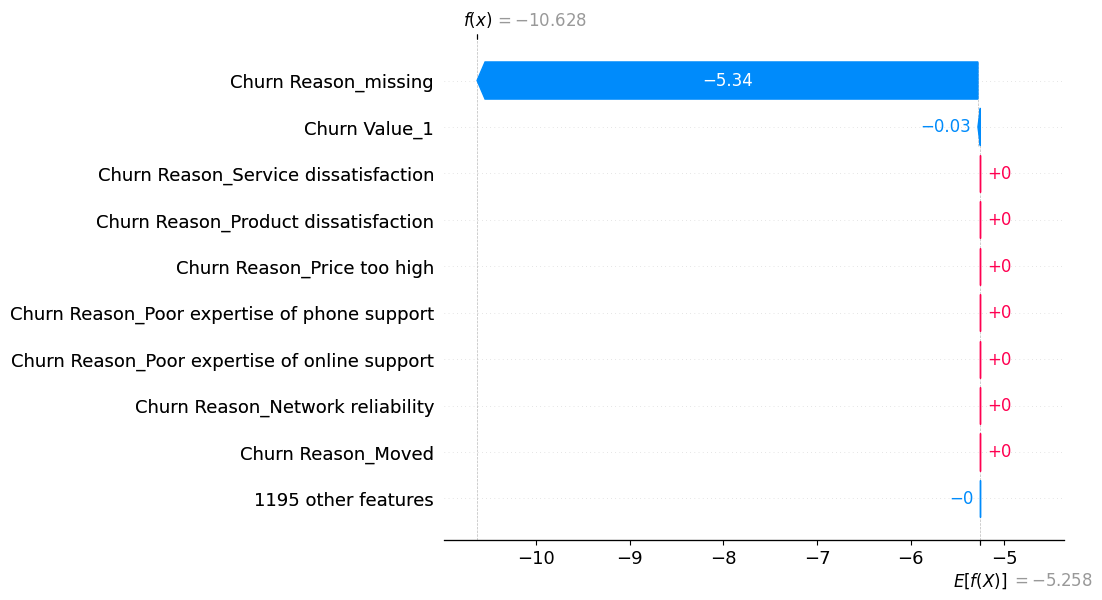

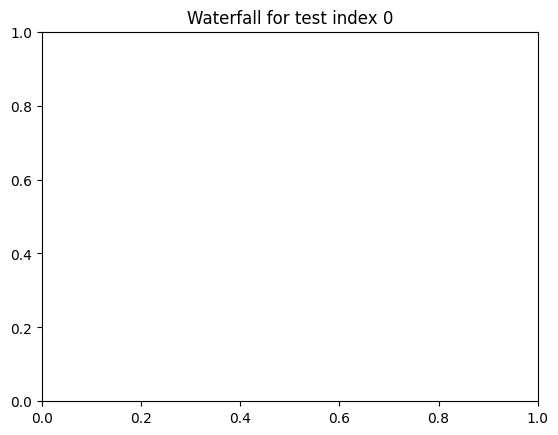

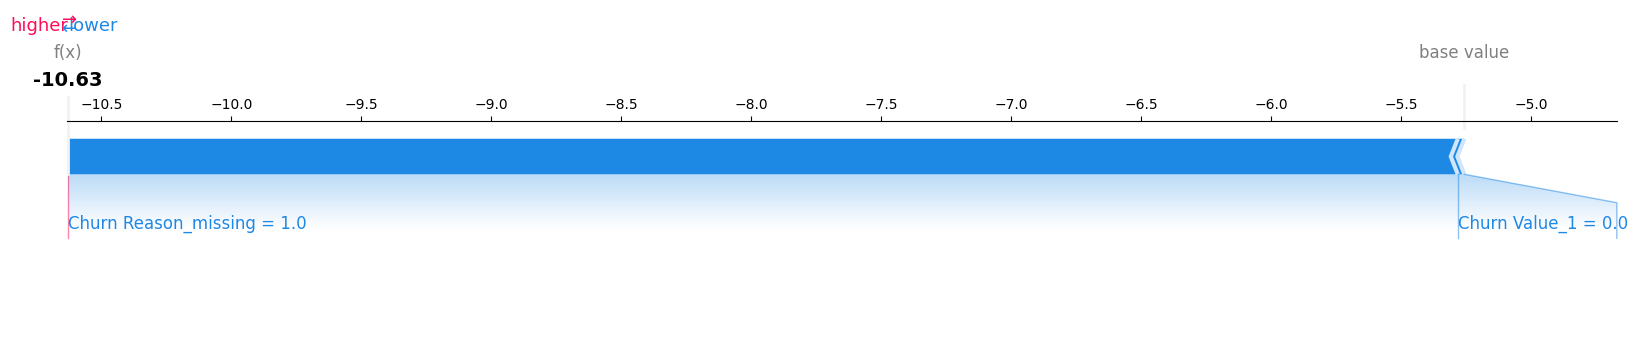

<Figure size 640x480 with 0 Axes>

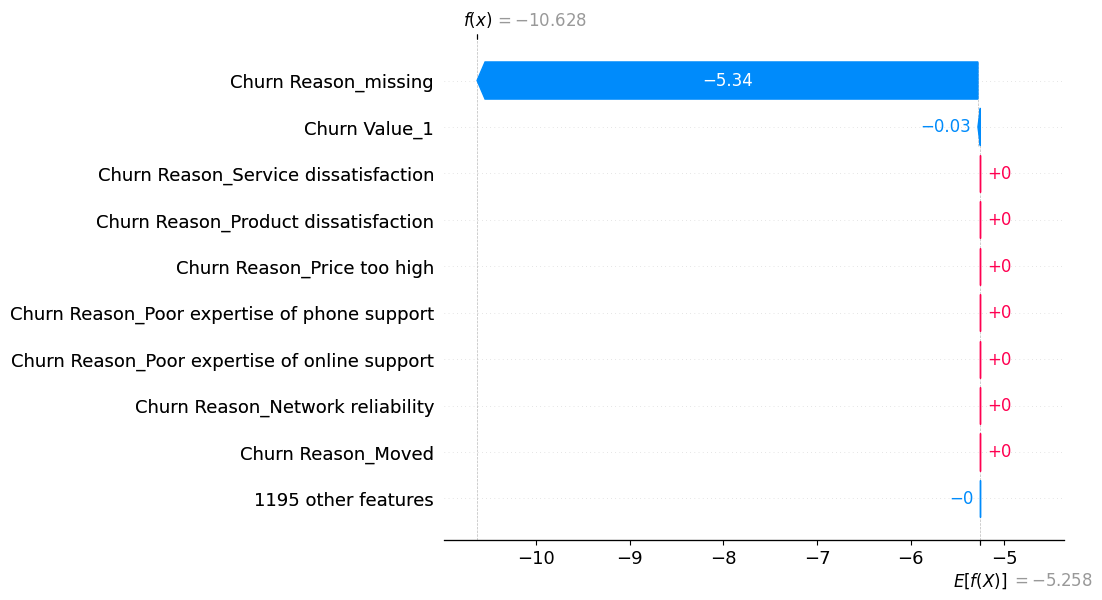

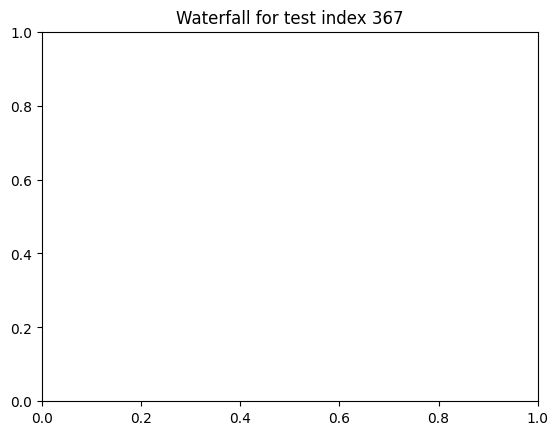

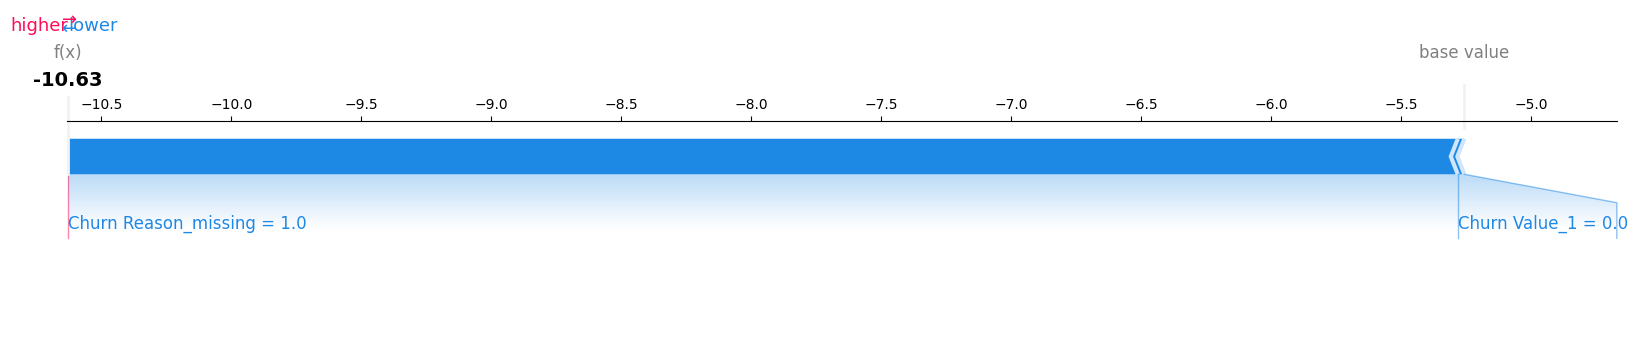

<Figure size 640x480 with 0 Axes>

In [38]:
# 7. Local explanations: select 5 customer profiles
# We'll pick: highest predicted churn prob, lowest prob, one misclassified churn, one misclassified not-churn, and a median case.
probs_all = probs
indices = np.arange(len(probs_all))
high_idx = indices[np.argmax(probs_all)]
low_idx = indices[np.argmin(probs_all)]
median_idx = indices[np.argsort(probs_all)[len(probs_all)//2]]
# misclassified churn (pred=0 but true=1) and misclassified not-churn (pred=1 but true=0)
mis_cl = None
mis_ncl = None
for i in indices:
    if preds[i]==0 and y_test.values[i]==1 and mis_cl is None:
        mis_cl = i
    if preds[i]==1 and y_test.values[i]==0 and mis_ncl is None:
        mis_ncl = i
# fallback if not found
sample_idxs = [high_idx, low_idx, median_idx]
if mis_cl is not None:
    sample_idxs.append(mis_cl)
if mis_ncl is not None:
    sample_idxs.append(mis_ncl)
# ensure unique and length 5
sample_idxs = list(dict.fromkeys(sample_idxs))[:5]
print('Selected sample indices (in test set):', sample_idxs)

# Create local plots
for i, idx in enumerate(sample_idxs):
    sv = shap_vals_pos[idx]
    x_row = X_test_trans[idx]
    # waterfall
    plt.figure()
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value, sv, feature_names=feature_names, max_display=10)
    plt.title(f'Waterfall for test index {idx}')
    plt.savefig(os.path.join(OUTPUT_DIR, f'waterfall_{i}_idx{idx}.png'), bbox_inches='tight')
    # force plot as html
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value, sv, x_row, feature_names=feature_names, matplotlib=True, show=True)
    plt.savefig(os.path.join(OUTPUT_DIR, f'force_{i}_idx{idx}.png'), bbox_inches='tight')

In [39]:
# 8. Export a CSV with predictions and key SHAP contributions for inspection
X_test_reset = X_test.reset_index(drop=True)
out = X_test_reset.copy()
out['y_true'] = y_test.reset_index(drop=True)
out['y_pred_prob'] = probs_all
out['y_pred'] = preds

# add top 10 shap contributions
for j in range(10):
    if j < len(feature_names):
        out[f'shap_contrib_{j+1}_feat'] = np.array(feature_names)[np.argsort(-np.abs(shap_vals_pos), axis=1)][:, j]
        out[f'shap_contrib_{j+1}_val'] = np.take_along_axis(shap_vals_pos, np.argsort(-np.abs(shap_vals_pos), axis=1), axis=1)[:, j]

out.to_csv(os.path.join(OUTPUT_DIR, 'test_predictions_with_shap.csv'), index=False)
print('Exported test_predictions_with_shap.csv and plot PNGs.')

# End of script
print('Done')

Exported test_predictions_with_shap.csv and plot PNGs.
Done
